# Object Detection [Classification + Localization]

 # 1: Importing Libraries

In [3]:
import os

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import tensorflow as tf
import tensorflow_datasets as tfds

 # 2: Visualization Utilities

In [6]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

In [7]:
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)
    
def draw_bounding_boxes_on_image(image, boxes,color=[], thickness=1, display_str_list=()):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N,4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes [i,1], boxes [i,0], boxes [i,3], boxes [i,2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color='red', thickness = 1 , display_str_list = None, use_normalized_coordinates = True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left,top)], width=thickness, fill=color)



In [8]:
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    batch_train_ds = training_dataset.unbatch().batch(N)
    
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
        for training_digits, (training_labels, training_bboxes) in training_dataset:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break

    validation_labels = np.argmax(validation_labels, axis = 1) 
    training_labels = np.argmax(training_labels, axis = 1)
    return (training_digits, training_labels, training_bboxes, validation_digits, validation_labels, validation_bboxes)

In [9]:
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
def create_digits_from_local_fonts(n):
    font_labels = []
    img = PIL.Image.new('LA', (75*n, 75), color = (0,255))
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75, 0 if i < 10 else -4), str(i%10), fill=(255,255), font = font1 if i <10 else font2)
    font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis = 0) [n, 75*75])
    return font_digits, font_labels

In [10]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    n = 10
    indexes = np.random.choice(len(predictions), size = n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]
    
    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]
    
    if len(pred_bboxes) > 0:
        n_pred_bboxes = pred_bboxes[indexes]
    
    if len(bboxes) > 0:
        n_bboxes = bboxes[indexes]
        
    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize=(20,4))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
    for i in range(n):
        ax = fig.add_subplot(1,n, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])
            
        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])
            
        img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i],boxes = np.asarray(bboxes_to_plot),color=['red', 'green'],display_str_list=["True", 'Pred'])
        
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])
        
        if n_predictions[i] != n_labels[i]:
            ax.xais.label.set_color('red')
            
        plt.imshow(img_to_draw)
        
        if len(iou) > i:
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color = color, transform=ax.transAxes)

In [11]:
def plot_metrics(metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label = metric_name)
    plt.plot(history.history['val_'+ metric_name], color='green', label = 'val_' + metric_name)

# 3. Loading and Preprocessing the dataset

In [13]:
strategy = tf.distribute.get_strategy()
strategy.num_replicas_in_sync

1

In [14]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [15]:
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32) / 255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin/75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

In [16]:
def get_training_dataset():
    
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset =dataset.map(read_image_tfds, num_parallel_calls = 16)
        dataset =dataset.shuffle(5000, reshuffle_each_iteration = True)
        dataset =dataset.repeat()
        dataset =dataset.batch(BATCH_SIZE, drop_remainder =True)
        dataset =dataset.prefetch(-1)
    return dataset

In [17]:
def get_validation_dataset():
    
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls = 16)
        dataset = dataset.batch(10000, drop_remainder = True)
        dataset = dataset.repeat()
    return dataset

In [18]:
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

In [19]:
(training_digits, training_labels, training_bboxes, validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

# Visualize Data

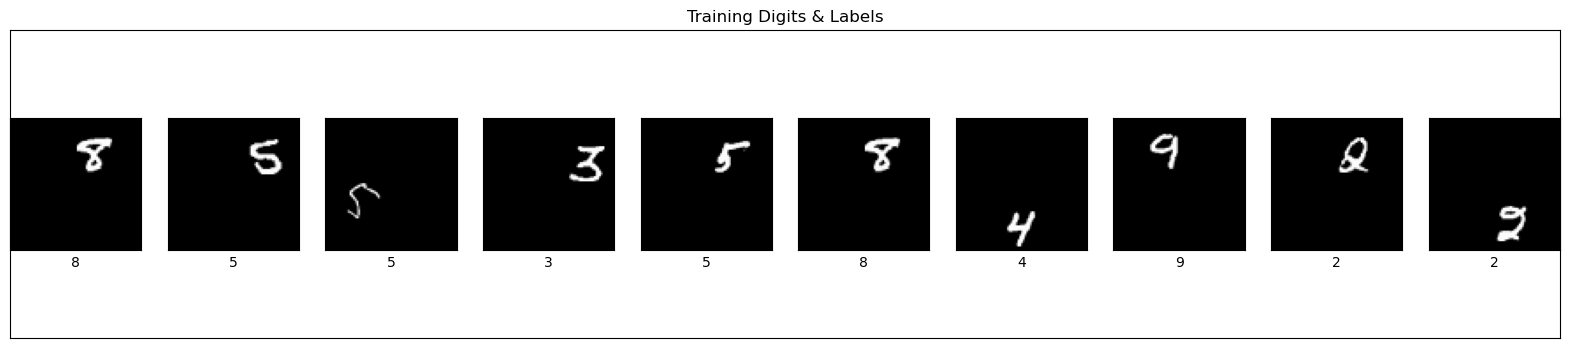

In [21]:
display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "Training Digits & Labels")

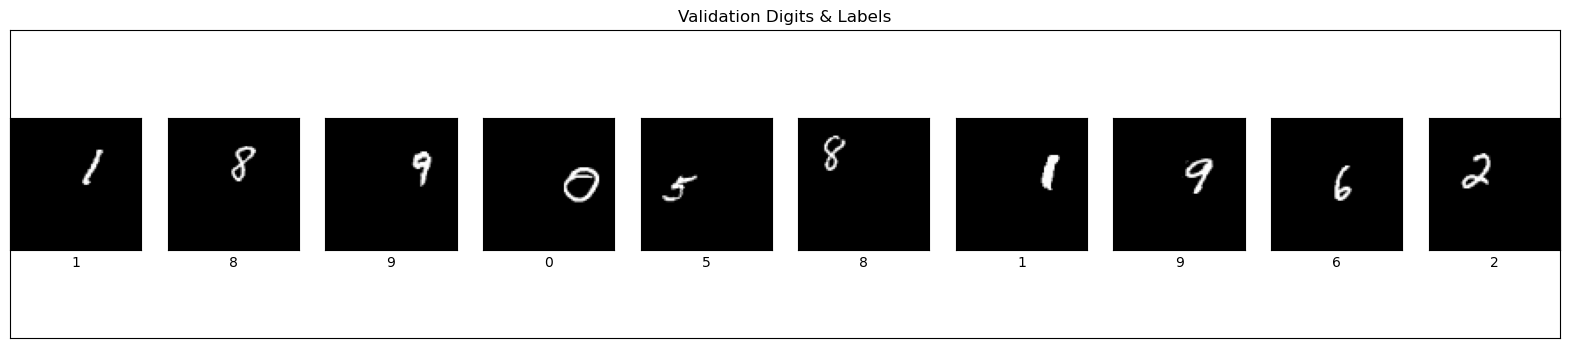

In [22]:
display_digits_with_boxes(validation_digits, validation_labels,
validation_labels, np.array([]), validation_bboxes,
np.array([]), "Validation Digits & Labels")

# 4: Define the Network

In [24]:
def feature_extractor(inputs):
    x= tf.keras.layers. Conv2D(16, activation ='relu', kernel_size=3, input_shape=(75,75,1)) (inputs)
    x= tf.keras.layers. AveragePooling2D((2,2))(x)
    x= tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x= tf.keras.layers.AveragePooling2D((2,2))(x)
    x= tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x= tf.keras.layers.AveragePooling2D((2,2))(x)
    
    return x

In [25]:
def dense_layers(inputs):
    x= tf.keras.layers.Flatten()(inputs)
    x= tf.keras.layers.Dense(128, activation='relu') (x)
    return x

In [26]:
def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation="softmax", name="classification")(inputs)
    return classification_output

In [27]:
def bounding_box_regression(inputs):
    bounding_box_regression_output= tf.keras.layers.Dense(4, name="bounding_box")(inputs)
    return bounding_box_regression_output

In [28]:
def final_model(inputs):
    feature_cnn =feature_extractor(inputs)
    dense_output =dense_layers(feature_cnn)
    classification_output =classifier(dense_output)
    bounding_box_output =bounding_box_regression(dense_output)
    model =tf.keras.Model(inputs =inputs, outputs= [classification_output, bounding_box_output])
    return model

In [29]:
def define_and_compile_model(inputs):
    model =final_model(inputs)
    model.compile(optimizer ='adam', loss = {'classification': 'categorical_crossentropy','bounding_box': 'mse'}, metrics ={'classification': 'accuracy', 'bounding_box': 'mse'})
    return model

In [30]:
with strategy.scope():
    inputs=tf.keras.layers.Input(shape=(75,75,1,))
    model=define_and_compile_model(inputs)
model.summary()

C:\Users\KIIT0001\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 36, 36,    │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 17, 17,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 7, 7, 64)  │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 10)        │      1,290 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bounding_box        │ (None, 4)         │        516 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 426,638 (1.63 MB)

 Trainable params: 426,638 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

# 5: Train and Validate the Model

In [62]:
EPOCHS = 20
steps_per_epoch = 60000 // BATCH_SIZE
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=1, epochs = EPOCHS)
loss, classification_loss, bounding_box_loss, classification_acc, bounding_box_mse = model.evaluate(validation_dataset, steps = 1)
print("\n--------------------------\n")
print("Validation Accuracy: ", classification_acc)
print("\n--------------------------\n")

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 75s 77ms/step - bounding_box_loss: 18.2453 - bounding_box_mse: 4.3459 - classification_accuracy: 0.1074 - classification_loss: 0.0901 - loss: 18.3354 - val_bounding_box_loss: 20.9677 - val_bounding_box_mse: 5.0029 - val_classification_accuracy: 0.1234 - val_classification_loss: 0.0899 - val_loss: 21.0575
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - bounding_box_loss: 21.1951 - bounding_box_mse: 4.7667 - classification_accuracy: 0.1306 - classification_loss: 0.0899 - loss: 21.2849 - val_bounding_box_loss: 21.1142 - val_bounding_box_mse: 4.2001 - val_classification_accuracy: 0.1577 - val_classification_loss: 0.0895 - val_loss: 21.2038
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - bounding_box_loss: 20.2870 - bounding_box_mse: 5.2955 - classification_accuracy: 0.1735 - classification_loss: 0.0883 - loss: 20.3753 - val_bounding_box_loss: 20.3786 - val_bounding_box_mse: 13.2230 - val_classification_accuracy: 0.2624 - val_classific

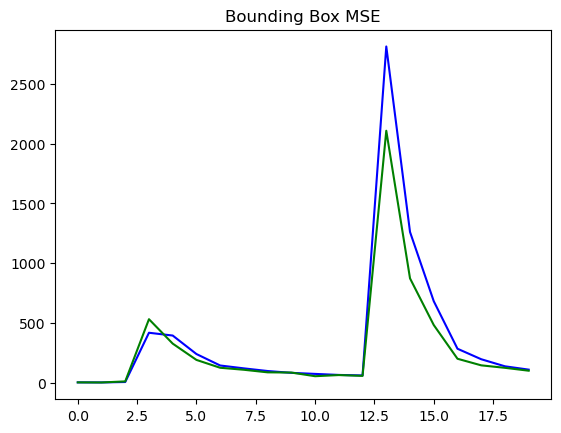

In [64]:
plot_metrics("bounding_box_mse", "Bounding Box MSE")

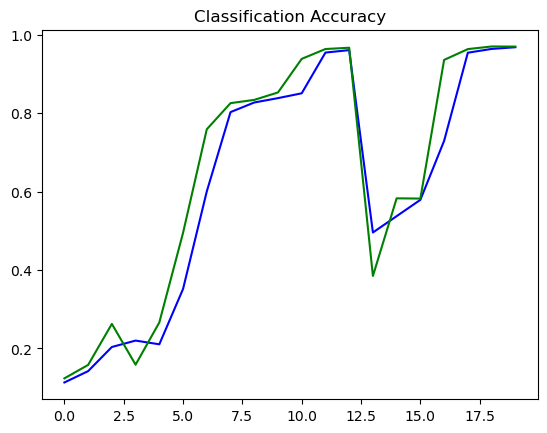

In [66]:
plot_metrics("classification_accuracy", "Classification Accuracy")

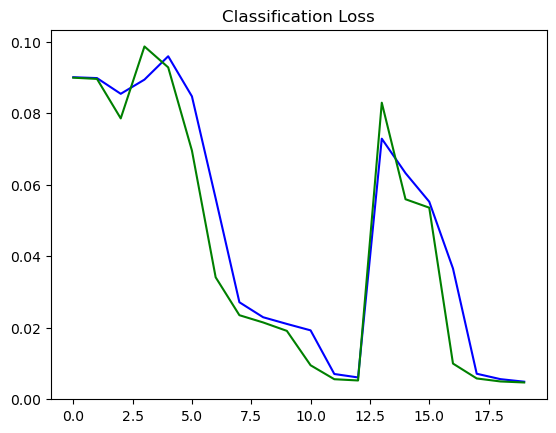

In [70]:
plot_metrics("classification_loss", "Classification Loss")

In [72]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)
    smoothing_factor= 1e-10
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum (xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum (ymax_pred, ymax_true)
    
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    
    overlap_area = np.maximum ((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    
    return iou

In [76]:
prediction = model.predict(validation_digits, batch_size= 64)
predicted_labels = np.argmax(prediction[0], axis = 1)
prediction_bboxes = prediction[1]

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


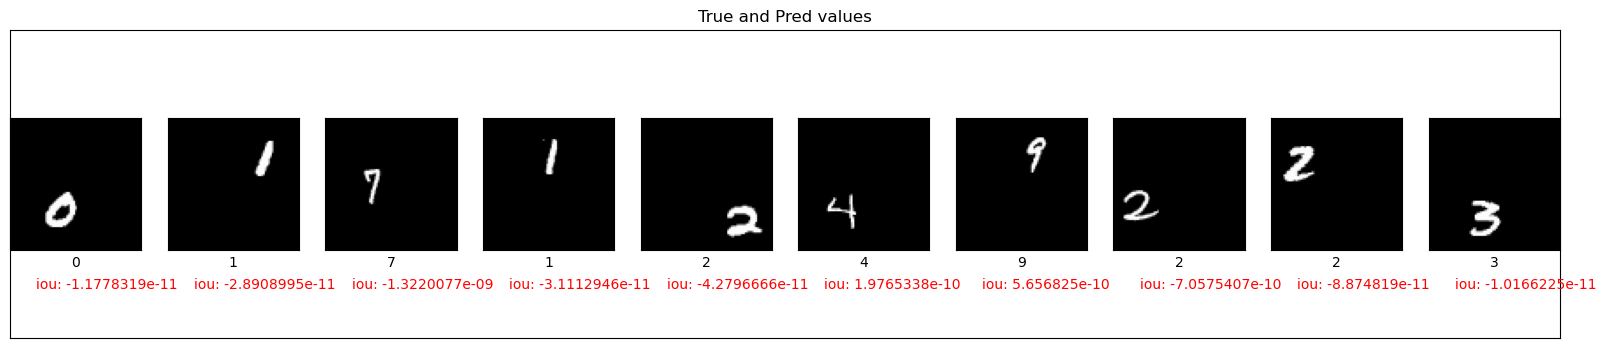

In [80]:
iou = intersection_over_union(prediction_bboxes, validation_bboxes)
iou_threshold = 0.6
display_digits_with_boxes(validation_digits, predicted_labels, validation_labels,
                          prediction_bboxes, validation_bboxes, iou, "True and Pred values")